In [3]:
import matplotlib.pyplot as plt
from mab.environment import *
from mab.ts_learner import *
from mab.ucb_learner import *



prices = [500, 690, 750, 850]

#Customers
customerParams = zip([200,200,200,200], [50,50,50,50])
#discounts
discounts = np.array([0.0, 0.5, 0.10, 0.25])
#Conversion Rates for item 2 [discountedPrice x Class]
conv_rate2 = np.array([[0.1, 0.2, 0.15, 0.2],
                    [0.15, 0.25, 0.2, 0.25],
                    [0.2, 0.35, 0.25, 0.4],
                    [0.4, 0.45, 0.35, 0.6]])

n_classes = 4

def generate_conversion_rate(prices):
    val = np.random.uniform(size=(len(prices)))
    conversion_rates = np.sort(val)[::-1]
    return conversion_rates

T = 300

conv_rate1 = generate_conversion_rate(prices)
n_customers =  1000
 
max_conv = np.argmax(conv_rate1)

opt = conv_rate1[max_conv]
print(opt)

0.9746308499152503


In [ ]:
n_experiments = 200
ts_rewards_per_experiment = []
u_rewards_per_experiment = []

for e in range(0, n_experiments):
    env = Environment(customerParams, discounts, prices, conv_rate1, conv_rate2, [], [])
    ts_learner =TS_Learner(n_arms=len(prices))
    u_learner = UCB(n_arms=len(prices))
    for t in range(0,T):
        pulled_arm = ts_learner.pull_arm()
        reward = env.round(pulled_arm)
        ts_learner.update(pulled_arm,reward)

        pulled_arm = u_learner.pull_arm()
        reward = env.round(pulled_arm)
        u_learner.update(pulled_arm,reward)

    ts_rewards_per_experiment.append(ts_learner.rewards)
    u_rewards_per_experiment.append(u_learner.rewards)

/home/famorosini/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/famorosini/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/famorosini/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/famorosini/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


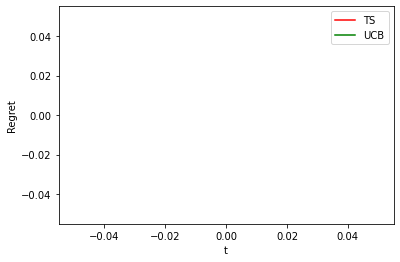

In [4]:
plt.figure(0)
plt.xlabel("t")
plt.ylabel("Regret")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - u_rewards_per_experiment, axis=0)), 'g')
plt.legend(["TS", "UCB"])
plt.show()